In [4]:
from pygranso.private.getNvar import getNvarTorch
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct

import torch
import torch.nn as nn

import time

# Interval is [0.5, 2.5]

In [5]:
class DeepliftingSimpleModel(nn.Module):
    def __init__(
        self,
    ):
        super(DeepliftingSimpleModel, self).__init__()

        # One simple linear layer the input size will be 3
        self.intermediate_linear_layer = nn.Linear(3, 2)
        self.linear_layer = nn.Linear(2, 1)

        # Simple input
        self.x = nn.Parameter(torch.randn(1, 3))

    def get_linear_layer(self, inputs):
        return self.intermediate_linear_layer(inputs)

    def get_output_layer(self, inputs):
        output = self.linear_layer(inputs)

        # a & b are known for this example
        a, b = 0.5, 2.5
        return a + (b - a) / 2.0 * (torch.sin(output) + 1)

    def forward(self, inputs=None):
        if inputs is None:
            x = self.x
        else:
            x = inputs

        # Feed x into the very simple layer
        output = self.get_linear_layer(x)
        output = self.get_output_layer(output)
        return output


def objective(x):
    return torch.sin(10 * torch.pi * x) / (2 * x) + (x - 1) ** 4


def deeplifting_fn(model, objective):
    """
    Combined funtion used for PyGranso
    """
    outputs = model(inputs=None)

    # Get x1 and x2 so we can add the bounds
    # outputs = torch.sigmoid(outputs)
    # x = outputs.mean(axis=0)
    # print(f'Output x {x}')
    f = objective(outputs)

    # Inequality constraint
    ci = None

    # Equality constraing
    ce = None

    return f, ci, ce

In [6]:
device = torch.device('cpu')

# Deeplifting model with skip connections
model = DeepliftingSimpleModel()

model = model.to(device=device, dtype=torch.double)
nvar = getNvarTorch(model.parameters())

# Setup a pygransoStruct for the algorithm
# options
opts = pygransoStruct()

# Inital x0
x0 = (
    torch.nn.utils.parameters_to_vector(model.parameters())
    .detach()
    .reshape(nvar, 1)
    .to(device=device, dtype=torch.double)
)

opts.x0 = x0
opts.torch_device = device
opts.print_frequency = 1
opts.limited_mem_size = 5
opts.stat_l2_model = False
opts.double_precision = True
opts.opt_tol = 1e-10
opts.maxit = 1000

# Set up the function with the results
# # Combined function
comb_fn = lambda model: deeplifting_fn(
    model,
    objective,
)  # noqa

# Run the main algorithm
start_time = time.time()
soln = pygranso(var_spec=model, combined_fn=comb_fn, user_opts=opts)
end_time = time.time()
total_time = end_time - start_time



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.2.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang               ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specifications:  

In [7]:
inputs = torch.randn(512, 3).to(device=device, dtype=torch.double)
inputs

tensor([[ 0.5963,  1.0763, -0.7313],
        [-1.3748, -1.3196, -1.0173],
        [ 0.0166, -1.1199,  0.0134],
        ...,
        [-0.5140,  0.0669,  0.1319],
        [-0.7815,  0.8295,  1.2709],
        [ 0.3782,  0.2306, -0.2541]], dtype=torch.float64)

In [8]:
(
    model.get_linear_layer(inputs)[:, 0].min(),
    model.get_linear_layer(inputs)[:, 0].max(),
    model.get_linear_layer(inputs)[:, 1].min(),
    model.get_linear_layer(inputs)[:, 1].max(),
)

(tensor(-22.9736, dtype=torch.float64, grad_fn=<MinBackward1>),
 tensor(12.9190, dtype=torch.float64, grad_fn=<MaxBackward1>),
 tensor(-10.9294, dtype=torch.float64, grad_fn=<MinBackward1>),
 tensor(18.0770, dtype=torch.float64, grad_fn=<MaxBackward1>))

In [21]:
x = torch.linspace(-23, 13, steps=50)
y = torch.linspace(-10, 18, steps=50)

In [22]:
x_flat = torch.meshgrid(x, y)[0].flatten()
y_flat = torch.meshgrid(x, y)[1].flatten()

In [23]:
inputs = torch.stack((x_flat, y_flat)).T.to(device=device, dtype=torch.double)

In [24]:
Z = model.get_output_layer(inputs)

In [25]:
Z = Z.reshape(50, 50).detach().cpu().numpy()

In [26]:
X, Y = torch.meshgrid(x, y)
X = X.numpy()
Y = Y.numpy()

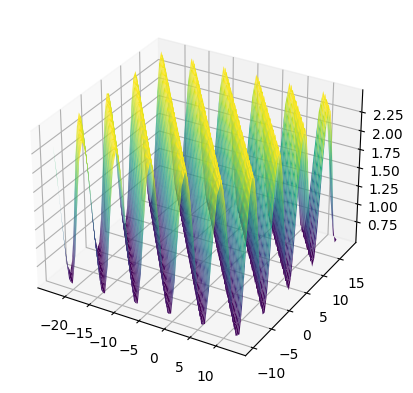

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Define the function
def f(x, y):
    return np.sin(np.sqrt(x**2 + y**2))


# # Create a meshgrid for our x, y values
# x = np.linspace(-5, 5, 100)
# y = np.linspace(-5, 5, 100)
# X, Y = np.meshgrid(x, y)
# Z = f(X, Y)

# Set up a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot a surface
ax.plot_surface(X, Y, Z, cmap='viridis')

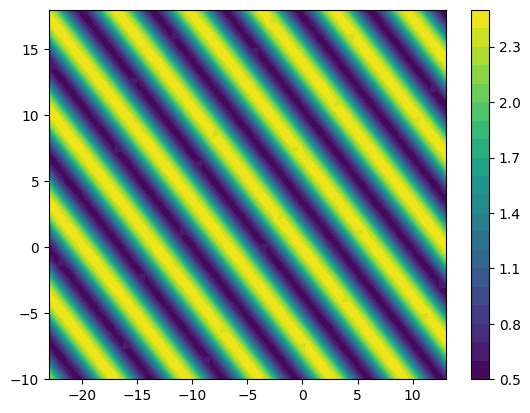

In [28]:
plt.figure()

# Create a contour plot
contour = plt.contourf(
    X, Y, Z, 20, cmap='viridis'
)  # contourf fills the regions between contours
plt.colorbar(contour)  # Show a colorbar that maps color to Z values

In [30]:
Z.min()

0.5000002142921557

In [37]:
test_x = torch.linspace(0.5, 2.5, 1000)
np.argmin(objective(test_x).cpu().numpy())

24

In [38]:
test_x[24]

tensor(0.5480)